<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-and-Clean-Data" data-toc-modified-id="Load-and-Clean-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load and Clean Data</a></span><ul class="toc-item"><li><span><a href="#Expand-the-df" data-toc-modified-id="Expand-the-df-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Expand the df</a></span></li></ul></li><li><span><a href="#Truncate-to-36-Months-from-Actual-Date" data-toc-modified-id="Truncate-to-36-Months-from-Actual-Date-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Truncate to 36 Months from Actual Date</a></span></li><li><span><a href="#Calculate-Difference-Column" data-toc-modified-id="Calculate-Difference-Column-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate Difference Column</a></span></li><li><span><a href="#Implement-Result-Summarization" data-toc-modified-id="Implement-Result-Summarization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Implement Result Summarization</a></span></li><li><span><a href="#Appendix:" data-toc-modified-id="Appendix:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Appendix:</a></span><ul class="toc-item"><li><span><a href="#Work-With-Diff-Column-Function" data-toc-modified-id="Work-With-Diff-Column-Function-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Work With Diff Column Function</a></span></li></ul></li></ul></div>

# Manual Testing / Debugging


In [1]:
import os
import sys
sys.executable

sys.path.append(os.path.dirname("Y:/buerki_r/20-06_kpi_app/src/"))

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
from src import data_dicts
from src.preprocess import *
from src.helpers import *

pd.set_option('precision', 2)

%load_ext autoreload
%autoreload 2

## Load and Clean Data

In [3]:
connection = connect_to_engine(server, db_name)
query = read_query("sql_statements/get_results_for_kpi_sheet.sql", n_years_back=3)
df = create_df(query, connection)
df = create_calculation_date_column(df)
df = trim_strings(df)
df = prettify_kpi_names(df)
df = impute_missing_mandant_values(df)
df = impute_missing_cardprofile_values(df)

In [4]:
# Check result
display(df.shape)
print(df["calculation_date"].max())
print(df["calculation_date"].min())

(29263, 8)

2020-06-30 00:00:00
2017-06-30 00:00:00


67
20
(29263, 8)


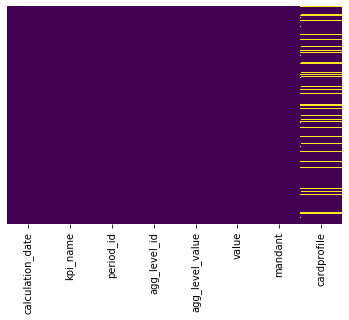

In [5]:
# Check results
print(df["agg_level_value"].nunique())
print(df["kpi_name"].nunique())
print(df.shape)
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis');

# df.to_csv("./tests/data/mock_preprocessed.csv", index=False)

In [6]:
df.head()

,calculation_date,kpi_name,period_id,agg_level_id,agg_level_value,value,mandant,cardprofile
0,2017-06-30,Umsatz Total,2,1,Overall,72762971.4900,Overall,None
1,2017-06-30,Umsatz Total,2,2,CC,69827240.2900,Overall,CC
2,2017-06-30,Umsatz Total,2,2,PP,2935731.2000,Overall,PP
3,2017-06-30,Umsatz Total,2,3,BCAG PP,12269.3800,BCAG,PP
4,2017-06-30,Umsatz Total,2,3,Bonus Card Verbund CC,39137499.0500,Bonus Card Verbund,CC


### Expand the df

In [7]:
months = pd.DataFrame({"calculation_date": sorted(df["calculation_date"].unique()), "merge_col": 0})
rest = df[["kpi_name", "period_id", "agg_level_id", "agg_level_value", "mandant", "cardprofile"]].drop_duplicates()
rest["merge_col"] = 0
temp_tbl = months.merge(rest, how="outer", on="merge_col")
temp_tbl = temp_tbl.drop(columns={"merge_col"})
temp_tbl = temp_tbl.sort_values(["kpi_name", "calculation_date"])

df_test = temp_tbl.merge(df, how="left", on=["calculation_date", "kpi_name", "period_id", "agg_level_id", "agg_level_value", "mandant", "cardprofile"]).reset_index(drop=True)

In [8]:
df_test

,calculation_date,kpi_name,period_id,agg_level_id,agg_level_value,mandant,cardprofile,value
0,2017-06-30,Anzahl aktive Konten Total,2,1,Overall,Overall,None,114874.0000
1,2017-06-30,Anzahl aktive Konten Total,2,2,CC,Overall,CC,104054.0000
2,2017-06-30,Anzahl aktive Konten Total,2,2,PP,Overall,PP,10820.0000
3,2017-07-31,Anzahl aktive Konten Total,2,1,Overall,Overall,None,114720.0000
4,2017-07-31,Anzahl aktive Konten Total,2,2,CC,Overall,CC,103906.0000
...,...,...,...,...,...,...,...,...
45172,2020-06-30,Umsatz Total,2,5,TUI VISA Card Gold,Bonus Card Verbund,CC,NaN
45173,2020-06-30,Umsatz Total,2,5,UZH Alumni VBC Exclusive,Bonus Card Verbund,CC,NaN
45174,2020-06-30,Umsatz Total,2,5,TUI VISA Card Prepaid,Bonus Card Verbund,PP,NaN
45175,2020-06-30,Umsatz Total,2,5,Reserviert IT nicht benutzen,Bonus Card Verbund,CC,NaN


67
20
(45177, 8)


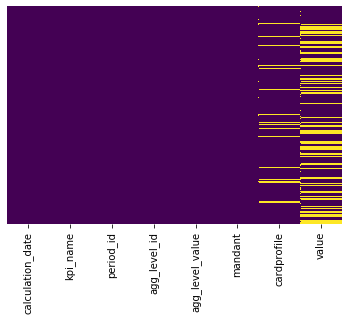

In [9]:
# Check results
print(df_test["agg_level_value"].nunique())
print(df_test["kpi_name"].nunique())
print(df_test.shape)
sns.heatmap(df_test.isnull(), yticklabels=False, cbar=False, cmap='viridis');

# df.to_csv("./tests/data/mock_preprocessed.csv", index=False)

In [10]:
df_test["kpi_name"].value_counts() / df_test["calculation_date"].nunique()

Nr. TRX Ausland                 68.0
Anzahl gültige Konten Total     68.0
Nr. TRX Total                   68.0
Nr. TRX POS                     68.0
Umsatz Internet                 68.0
Umsatz POS                      68.0
Nr. TRX Internet                68.0
Nr. TRX Bargeld                 67.0
Umsatz Bargeld                  67.0
Nr. TRX Inland                  66.0
Umsatz Ausland                  65.0
Umsatz Inland                   65.0
Umsatz Total                    64.0
Nr. TRX Kontaktlos              62.0
Umsatz Kontaktlos               62.0
Nr. TRX Mobile Payment POS      57.0
Umsatz Mobile Payment POS       57.0
Nr. TRX Mobile Payment Inapp    55.0
Umsatz Mobile Payment Inapp     55.0
Anzahl aktive Konten Total       3.0
Name: kpi_name, dtype: float64

## Truncate to 36 Months from Actual Date

In [11]:
actual_date = "2020-06-30"

df = truncate_data_to_actual_date(df, actual_date)
n_years = calculate_max_n_years_available(df)
df = truncate_data_n_years_back(df, actual_date, n_years)

assert df["calculation_date"].nunique() == (n_years * 12) + 1

print(n_years)
print(df.shape)
print(df["calculation_date"].max())
print(df["calculation_date"].min())

3
(29263, 8)
2020-06-30 00:00:00
2017-06-30 00:00:00


## Calculate Difference Column

In [12]:
df["temp_index"] = pd.to_datetime(df["calculation_date"], format="%Y-%m-%d")
df.set_index("temp_index", inplace=True)

In [13]:
df["diff_value"] = df.groupby(
    ["kpi_name", "period_id", "agg_level_id", "agg_level_value", "mandant"]
)["value"].pct_change(12)

In [14]:
df.reset_index(drop=True, inplace=True)
df

,calculation_date,kpi_name,period_id,agg_level_id,agg_level_value,value,mandant,cardprofile,diff_value
0,2017-06-30,Umsatz Total,2,1,Overall,72762971.4900,Overall,None,NaN
1,2017-06-30,Umsatz Total,2,2,CC,69827240.2900,Overall,CC,NaN
2,2017-06-30,Umsatz Total,2,2,PP,2935731.2000,Overall,PP,NaN
3,2017-06-30,Umsatz Total,2,3,BCAG PP,12269.3800,BCAG,PP,NaN
4,2017-06-30,Umsatz Total,2,3,Bonus Card Verbund CC,39137499.0500,Bonus Card Verbund,CC,NaN
...,...,...,...,...,...,...,...,...,...
29258,2020-06-30,Anzahl gültige Konten Total,1,5,VISA LibertyCard Plus Credit,7747.0000,Liberty,CC,-0.0457009115545700911554570091
29259,2020-06-30,Anzahl gültige Konten Total,1,5,VISA LibertyCard Prepaid,14891.0000,Liberty,PP,-0.1720322490964692799555184876
29260,2020-06-30,Anzahl aktive Konten Total,2,1,Overall,93397.0000,Overall,None,-0.0547149378055322206815582523
29261,2020-06-30,Anzahl aktive Konten Total,2,2,CC,85267.0000,Overall,CC,-0.0594237430229223200300041918


In [15]:
print(df_diff.shape)
df_diff.head().style.format({"value": "{:,.0f}"})

NameError: name 'df_diff' is not defined

In [ ]:
# Display for one unique KPI-Instance
df_ex = df_diff.loc[(df_diff["kpi_name"] == "Umsatz Total")
            & (df_diff["agg_level_value"] == "Bonus Card Verbund")].copy()

df_ex.sort_values(["period_id", "calculation_date"], ascending=False, inplace=True)
df_ex.reset_index().style.format({"value": "{:,.0f}"})

## Implement Result Summarization

In [ ]:
def sum_values_for_multiple_periods(df: pd.DataFrame, n_months_sum: int) -> pd.DataFrame:
    """blablabla."""
    df_sum = df.copy()
    df_sum["calculation_date"] = pd.to_datetime(df_sum["calculation_date"], format="%Y-%m-%d")
    df_sum.set_index("calculation_date", inplace=True)
    grouper = df_sum.groupby([pd.Grouper(freq=f'{n_months_sum}M'), "kpi", "period_id", "agg_level_id", "agg_level_value", "mandant"])
    df_sum = pd.DataFrame(grouper['value'].sum()).reset_index()
    df_sum=df_sum.loc[df_sum["period_id"] != 1]
    return df_sum

In [ ]:
df.shape

In [ ]:
n_months_sum = 3

df_sum = sum_values_for_multiple_periods(df, n_months_sum)

# Check shape
df_sum.shape

In [ ]:
def replace_values_with_new_sums(df: pd.DataFrame, df_sum: pd.DataFrame) -> pd.DataFrame:
    """blablabla."""
    df = pd.merge(df, df_sum, on=["calculation_date", "kpi", "period_id", "agg_level_id", "agg_level_value", "mandant"], how="left", suffixes=("", "_y"))
    df['value'] = np.where((df['value_y'].notnull()), df["value_y"], df["value"])
    df.drop(["value_y"], axis=1, inplace=True)
    return df

In [ ]:
df_sum = replace_values_with_new_sums(df, df_sum)

In [ ]:
df_sum.shape

In [ ]:
# Testing
df_sum.loc[(df_sum["agg_level_value"] == "Overall") 
            & (df_sum["period_id"] == 2) 
            & (df_sum["kpi"] == "Nr. TRX Ausland")
            ].style.format({"value": "{:,.0f}"})

## Appendix: 

Attention if a period is missing, the diffs are wrong for all calculation up to that period. To get valid results you have to expand the dataframe! If you leave NaN values for expanded rows with no original values, the diff will be calculated from the last available value from an earlier period.

### Work With Diff Column Function

In [16]:
idx = pd.date_range(end="2020-06-30", periods=37, freq="M")
kpi_name = ["kpi_1"] * 37
value = range(1, 38)

In [17]:
df_test = pd.DataFrame(zip(idx, kpi_name, value), columns=["calculation_date", "kpi_name", "value"])

In [18]:
df_test

,calculation_date,kpi_name,value
0,2017-06-30,kpi_1,1
1,2017-07-31,kpi_1,2
2,2017-08-31,kpi_1,3
3,2017-09-30,kpi_1,4
4,2017-10-31,kpi_1,5
5,2017-11-30,kpi_1,6
6,2017-12-31,kpi_1,7
7,2018-01-31,kpi_1,8
8,2018-02-28,kpi_1,9
9,2018-03-31,kpi_1,10


In [19]:
df_test["temp_index"] = pd.to_datetime(df_test["calculation_date"], format="%Y-%m-%d")
df_test.set_index("temp_index", inplace=True)

In [20]:
df_test["diff_value"] = df_test.groupby(
    ["kpi_name"]
)["value"].pct_change(12)
df_test.reset_index(drop=True, inplace=True)
df_test

,calculation_date,kpi_name,value,diff_value
0,2017-06-30,kpi_1,1,NaN
1,2017-07-31,kpi_1,2,NaN
2,2017-08-31,kpi_1,3,NaN
3,2017-09-30,kpi_1,4,NaN
4,2017-10-31,kpi_1,5,NaN
5,2017-11-30,kpi_1,6,NaN
6,2017-12-31,kpi_1,7,NaN
7,2018-01-31,kpi_1,8,NaN
8,2018-02-28,kpi_1,9,NaN
9,2018-03-31,kpi_1,10,NaN


In [21]:
df_tmp = df_test.copy()
df_tmp["kpi_name"] = "kpi_2"
df_tmp.drop([4, 35], inplace=True)

In [22]:
df_test = df_test.append(df_tmp)

In [23]:
months = pd.DataFrame({"calculation_date": sorted(df_test["calculation_date"].unique()), "key": 0})
kpi = pd.DataFrame({"kpi_name": df_test["kpi_name"].unique(), "key": 0})
temp_tbl = months.merge(kpi, how="outer", on="key")
temp_tbl = temp_tbl.drop(columns={"key"})
temp_tbl = temp_tbl.sort_values(["kpi_name", "calculation_date"])

df_test = temp_tbl.merge(df_test, how="left", on=["calculation_date", "kpi_name"]).reset_index(drop=True)

In [24]:
df_test["temp_index"] = pd.to_datetime(df_test["calculation_date"], format="%Y-%m-%d")
df_test.set_index("temp_index", inplace=True)

In [25]:
df_test["diff_value"] = df_test.groupby(
    ["kpi_name"]
)["value"].pct_change(12)
df_test.reset_index(drop=True, inplace=True)
df_test.loc[df_test["kpi_name"] == "kpi_2"]

,calculation_date,kpi_name,value,diff_value
37,2017-06-30,kpi_2,1.0,NaN
38,2017-07-31,kpi_2,2.0,NaN
39,2017-08-31,kpi_2,3.0,NaN
40,2017-09-30,kpi_2,4.0,NaN
41,2017-10-31,kpi_2,NaN,NaN
42,2017-11-30,kpi_2,6.0,NaN
43,2017-12-31,kpi_2,7.0,NaN
44,2018-01-31,kpi_2,8.0,NaN
45,2018-02-28,kpi_2,9.0,NaN
46,2018-03-31,kpi_2,10.0,NaN


In [48]:

df_test["temp_index"] = pd.to_datetime(df_test["calculation_date"], format="%Y-%m-%d")
df_test.set_index("temp_index", inplace=True)

df_sum = pd.DataFrame(
    df_test.groupby(["kpi_name"])
    .resample("3M")["value"]
    .sum()
).reset_index()

df_sum

,kpi_name,temp_index,value
0,kpi_1,2017-06-30,1.0
1,kpi_1,2017-09-30,9.0
2,kpi_1,2017-12-31,18.0
3,kpi_1,2018-03-31,27.0
4,kpi_1,2018-06-30,36.0
5,kpi_1,2018-09-30,45.0
6,kpi_1,2018-12-31,54.0
7,kpi_1,2019-03-31,63.0
8,kpi_1,2019-06-30,72.0
9,kpi_1,2019-09-30,81.0


In [49]:
grouper = df_test.groupby([pd.Grouper(freq='3M'), "kpi_name"])
df_sum = pd.DataFrame(grouper['value'].sum()).reset_index()

In [50]:
df_sum

,temp_index,kpi_name,value
0,2017-06-30,kpi_1,1.0
1,2017-06-30,kpi_2,1.0
2,2017-09-30,kpi_1,9.0
3,2017-09-30,kpi_2,9.0
4,2017-12-31,kpi_1,18.0
5,2017-12-31,kpi_2,13.0
6,2018-03-31,kpi_1,27.0
7,2018-03-31,kpi_2,27.0
8,2018-06-30,kpi_1,36.0
9,2018-06-30,kpi_2,36.0


In [60]:
df_test["rolling"] = df_test["value"].rolling(window=7).sum()

In [61]:
df_test.head(25)

,calculation_date,kpi_name,value,diff_value,rolling
temp_index,,,,,
2017-06-30,2017-06-30,kpi_1,1.0,NaN,NaN
2017-07-31,2017-07-31,kpi_1,2.0,NaN,NaN
2017-08-31,2017-08-31,kpi_1,3.0,NaN,NaN
2017-09-30,2017-09-30,kpi_1,4.0,NaN,NaN
2017-10-31,2017-10-31,kpi_1,5.0,NaN,NaN
2017-11-30,2017-11-30,kpi_1,6.0,NaN,NaN
2017-12-31,2017-12-31,kpi_1,7.0,NaN,28.0
2018-01-31,2018-01-31,kpi_1,8.0,NaN,35.0
2018-02-28,2018-02-28,kpi_1,9.0,NaN,42.0


In [63]:
df_test.sort_values(["kpi_name", "calculation_date"])

,calculation_date,kpi_name,value,diff_value,rolling
temp_index,,,,,
2017-06-30,2017-06-30,kpi_1,1.0,NaN,NaN
2017-07-31,2017-07-31,kpi_1,2.0,NaN,NaN
2017-08-31,2017-08-31,kpi_1,3.0,NaN,NaN
2017-09-30,2017-09-30,kpi_1,4.0,NaN,NaN
2017-10-31,2017-10-31,kpi_1,5.0,NaN,NaN
...,...,...,...,...,...
2020-02-29,2020-02-29,kpi_2,33.0,0.57,210.0
2020-03-31,2020-03-31,kpi_2,34.0,0.55,217.0
2020-04-30,2020-04-30,kpi_2,35.0,0.52,224.0


In [55]:
df.shape

(29263, 9)

In [59]:
df["value"] = df["value"].rolling(window=7).sum()
df_